# MSM estimation and validation

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to estimate a Markov state model (MSM) and do model validation;
we also show how to save and restore model and estimator objects.
For this notebook, you need to know how to do data loading/visualization as well as dimension reduction.


**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation for PyEMMA at [PyEMMA.org](http://www.pyemma.org) and for deeptime at [deeptime-ml.github.io](https://deeptime-ml.github.io/).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import mdshare
import pyemma
import deeptime as dt

## Loading MD data and repeating the clustering step

Let's load alanine dipeptide backbone torsions and discretise with 200 $k$-means centers...

In [2]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)

data = pyemma.coordinates.load(files, features=feat)

cluster = dt.clustering.KMeans(200, max_iter=50).fit(np.concatenate(data)[::10]).fetch_model()

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

/home/mho/Development/deeptime/deeptime/clustering/_kmeans.py:406: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


... and plot the free energy along with the cluster centers:

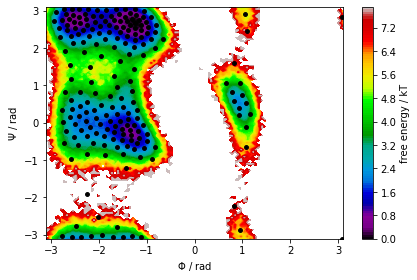

In [3]:
fig, ax = plt.subplots()
pyemma.plots.plot_free_energy(*np.concatenate(data).T, ax=ax, legacy=False)
ax.scatter(*cluster.cluster_centers.T, s=15, c='k')
ax.set_xlabel('$\Phi$ / rad') 
ax.set_ylabel('$\Psi$ / rad')
fig.tight_layout()

## Implied time scales and lag time selection

The first step after obtaining the discretized dynamics is finding a suitable lag time.
The systematic approach is to estimate MSMs at various lag times and observe how the implied timescales (ITSs) of these models behave.
In particular, we are looking for lag time ranges in which the implied timescales are constant.

To that end we iterate over a range of lagtimes and estimate a Markov state model for each of them, subsequently computing the four slowest (``k=4``) timescales from it.

In [4]:
dtrajs = [cluster.transform(traj) for traj in data]

lags = [1, 2, 5, 10, 20, 50]
timescales = []
for lag in tqdm(lags, leave=False):
    counts_estimator = dt.markov.TransitionCountEstimator(lag, "sliding")
    counts = counts_estimator.fit(dtrajs).fetch_model()
    counts = counts.submodel_largest()
    
    msm_estimator = dt.markov.msm.MaximumLikelihoodMSM()
    msm = msm_estimator.fit(counts).fetch_model()
    timescales.append(msm.timescales(k=4))

  0%|          | 0/6 [00:00<?, ?it/s]

$$\begin{eqnarray*}
T(n \tau) & = & (T(\tau))^n\\[0.75em]
\lambda(n \tau) & = & (\lambda(\tau))^n\\[0.75em]
\mathrm{ITS}(n \tau) & = & - \frac{n \tau}{\ln \lambda(n \tau)} = - \frac{n \tau}{\ln (\lambda(\tau))^n} = - \frac{\tau}{\ln \lambda(\tau)} = \mathrm{ITS}(\tau)
\end{eqnarray*}$$

We can pass the returned estimated timescales as "lagtime-timescale"-tuple to the `pyemma.plots.plot_implied_timescales()` function:

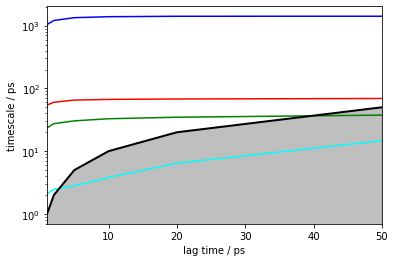

In [5]:
pyemma.plots.plot_implied_timescales((lags, timescales), units='ps');

The above plot tells us that there are three resolved processes (blue, red, green) which are largely invariant to the MSM lag time.
The fourth ITS (cyan) is smaller than the lag time (black line, grey-shaded area);
it corresponds to a process which is faster than the lag time and, thus, is not resolved.
Since the implied timescales are, like the corresponding eigenvalues, sorted in decreasing order,
we know that all other remaining processes must be even faster.

## Error bars for the timescales

For convenience, we provide in this workshop a small helper function that computes timescales from data. It can also provide error bars:

Computing implied timescales:   0%|          | 0/6 [00:00<?, ?it/s]

<AxesSubplot:xlabel='lag time / ps', ylabel='timescale / ps'>

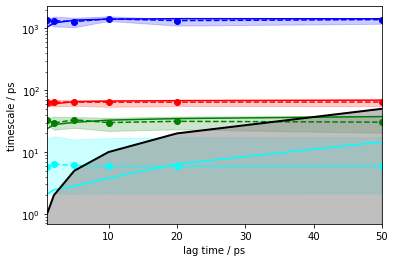

In [6]:
from timescales import implied_timescales_msm

lags = [1, 2, 5, 10, 20, 50]
its = implied_timescales_msm(dtrajs, lags, nits=4, bayesian=True)
pyemma.plots.plot_implied_timescales(its, units='ps')

## Effect of the discretization on the implied timescales

Let's look at the discretisation's influence on the ITSs:

In [7]:
lags = [1, 2, 5, 10, 20, 50]

cluster_20 = dt.clustering.KMeans(20, max_iter=50).fit(np.concatenate(data)[::10]).fetch_model()
its_20 = implied_timescales_msm([cluster_20.transform(x) for x in data], lags, nits=4)

cluster_50 = dt.clustering.KMeans(50, max_iter=50).fit(np.concatenate(data)[::10]).fetch_model()
its_50 = implied_timescales_msm([cluster_50.transform(x) for x in data], lags, nits=4)

cluster_100 = dt.clustering.KMeans(100, max_iter=50).fit(np.concatenate(data)[::10]).fetch_model()
its_100 = implied_timescales_msm([cluster_100.transform(x) for x in data], lags, nits=4);

Computing implied timescales:   0%|          | 0/6 [00:00<?, ?it/s]

/home/mho/Development/deeptime/deeptime/clustering/_kmeans.py:406: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


Computing implied timescales:   0%|          | 0/6 [00:00<?, ?it/s]

Computing implied timescales:   0%|          | 0/6 [00:00<?, ?it/s]

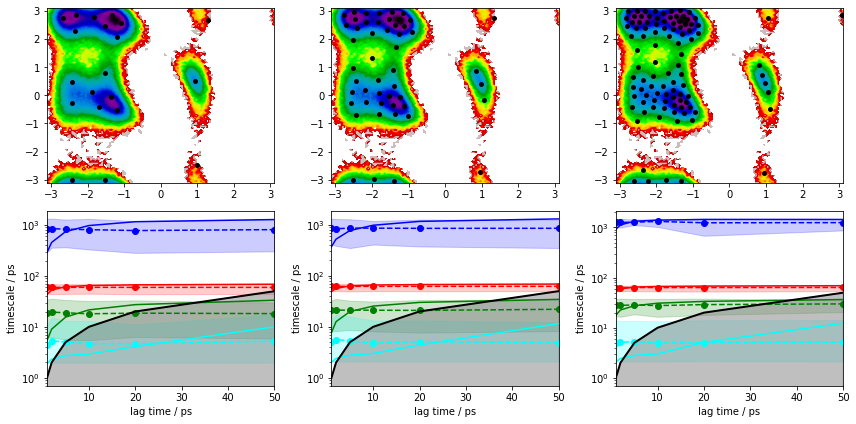

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

pyemma.plots.plot_free_energy(*np.concatenate(data).T, ax=axes[0, 0], cbar=False)
axes[0, 0].scatter(*cluster_20.cluster_centers.T, s=15, c='k')
pyemma.plots.plot_implied_timescales(its_20, ax=axes[1, 0], units='ps')

pyemma.plots.plot_free_energy(*np.concatenate(data).T, ax=axes[0, 1], cbar=False)
axes[0, 1].scatter(*cluster_50.cluster_centers.T, s=15, c='k')
pyemma.plots.plot_implied_timescales(its_50, ax=axes[1, 1], units='ps')

pyemma.plots.plot_free_energy(*np.concatenate(data).T, ax=axes[0, 2], cbar=False)
axes[0, 2].scatter(*cluster_100.cluster_centers.T, s=15, c='k')
pyemma.plots.plot_implied_timescales(its_100, ax=axes[1, 2], units='ps')

fig.tight_layout()

## Estimating the maximum likelihood Markov model

In [9]:
counts_estimator = dt.markov.TransitionCountEstimator(lagtime=10, count_mode='sliding')
counts = counts_estimator.fit(dtrajs).fetch_model().submodel_largest()

msm_estimator = dt.markov.msm.MaximumLikelihoodMSM()
msm = msm_estimator.fit(counts).fetch_model()

print(f'fraction of states used = {msm.state_fraction}')
print(f'fraction of counts used = {msm.count_fraction}')

fraction of states used = 1.0
fraction of counts used = 1.0


In [10]:
msm.timescales(k=4)

array([1389.49357661,   66.77846692,   32.87306238,    3.79872628])

The state space can be restricted to largest connected set (`submodel_largest()`) or any other selection of states:

In [11]:
counts = counts.submodel([0, 1, 3, 7])
print(f"States: {counts.states}, state symbols: {counts.state_symbols}")
msm = dt.markov.msm.MaximumLikelihoodMSM().fit(counts).fetch_model()

print(f'fraction of states used = {msm.state_fraction}')
print(f'fraction of counts used = {msm.count_fraction}')

States: [0 1 2 3], state symbols: [0 1 3 7]
fraction of states used = 0.02
fraction of counts used = 0.029638666666666667


And restricted even further, always based on the _states_ of the current count model.

In [12]:
counts = counts.submodel([0, 3])
print(f"States: {counts.states}, state symbols: {counts.state_symbols}")
msm = dt.markov.msm.MaximumLikelihoodMSM().fit(counts).fetch_model()

print(f'fraction of states used = {msm.state_fraction}')
print(f'fraction of counts used = {msm.count_fraction}')

States: [0 1], state symbols: [0 7]
fraction of states used = 0.01
fraction of counts used = 0.008978666666666666


## Estimating the Bayesian Markov model

In [13]:
count_estimator = dt.markov.TransitionCountEstimator(lagtime=10, count_mode='effective')
counts = count_estimator.fit(dtrajs).fetch_model()
counts = counts.submodel_largest()
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts).fetch_model()

In [14]:
stats = bayesian_msm.gather_stats('timescales', k=3)
stats.L, stats.R

(array([1204.94425113,   65.93860858,   29.60074225]),
 array([1560.39100009,   67.50109471,   37.07684347]))

## The Chapman-Kolmogorov test

To see whether our model satisfies Markovianity, we perform (and visualize) a Chapman-Kolmogorow (CK) test.
Since we aim at modeling the dynamics between metastable states rather than between microstates, this will be conducted in the space of metastable states.
The latter are identified automatically using PCCA++ (which is explained later).
We usually choose the number of metastable states according to the implied timescales plot by identifying a gap between the ITS.

In [15]:
test_estimator = dt.markov.msm.MaximumLikelihoodMSM(lagtime=10)
test_estimator.fit(dtrajs);

In [16]:
ck_validator = test_estimator.chapman_kolmogorov_validator(n_metastable_sets=4, mlags=10)
ck_test = ck_validator.fit(dtrajs).fetch_model()

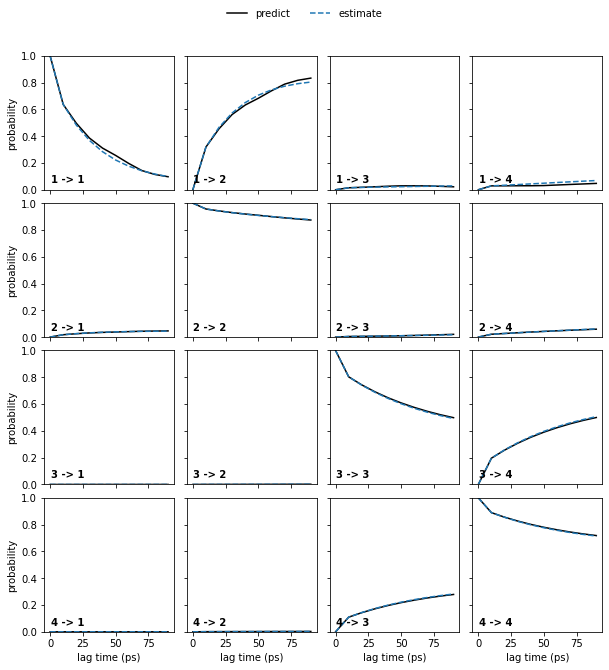

In [17]:
pyemma.plots.plot_cktest(ck_test, units='ps');

In [18]:
count_estimator = dt.markov.TransitionCountEstimator(lagtime=10, count_mode='effective')
counts = count_estimator.fit(dtrajs).fetch_model().submodel_largest()
bmsm_estimator = dt.markov.msm.BayesianMSM()
bmsm_estimator.fit(counts);

In [19]:
ck_val = bmsm_estimator.chapman_kolmogorov_validator(4, mlags=10)
cktest = ck_val.fit(dtrajs, progress=tqdm).fetch_model()

  0%|          | 0/9 [00:00<?, ?it/s]

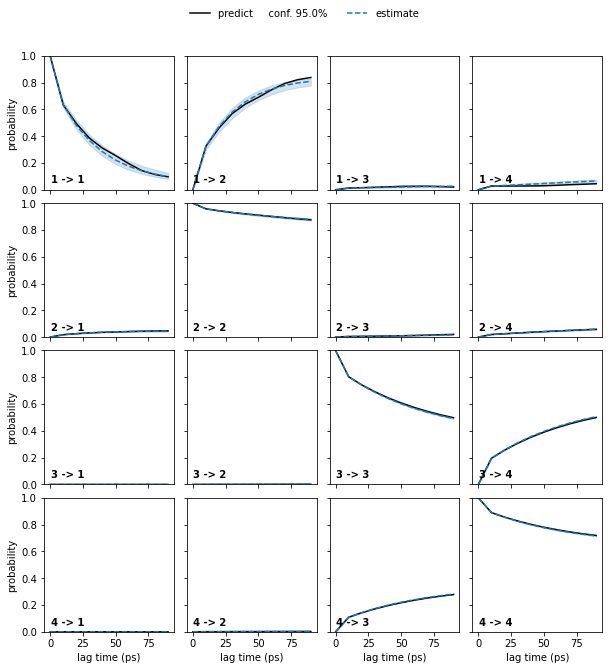

In [20]:
pyemma.plots.plot_cktest(cktest, units='ps');

## Persisting and restoring estimators

In [21]:
import pickle

with open('cluster_50.pkl', 'wb') as f:
    pickle.dump(cluster_50, f)
    
with open('cluster_50.pkl', 'rb') as f:
    cluster_50_restored = pickle.load(f)
    
print(cluster_50_restored.n_clusters)

50


In [22]:
with open('msm.pkl', 'wb') as f:
    pickle.dump(msm, f)
with open('msm.pkl', 'rb') as f:
    msm_restored = pickle.load(f)
    
print(f"Timescales {msm.timescales()}, restored {msm_restored.timescales()}")

Timescales [3.79404091], restored [3.79404091]


## Hands-on

#### Exercise 1

Load the heavy atom distances into memory, perform PCA and TICA (`lag=3`) with `dim=2`,
then discretize with $100$ $k$-means centers and a stride of $10$. Compare the two discretizations be generating implied timescale plots for both of them.

In [ ]:
feat =  #FIXME
feat. #FIXME
data =  #FIXME

pca = #FIXME
tica = #FIXME

pca_concatenated = np.concatenate(pca.get_output())
tica_concatenated = #FIXME

cls_pca_estimator = dt.clustering.KMeans(100, max_iter=50)
cls_pca = #FIXME
cls_tica = #FIXME

dtrajs_pca = [cls_pca.transform(pca.transform(traj)) for traj in data]
dtrajs_tica = # FIXME

def its(dtrajs, lags):
    models = []
    estimator = dt.markov.msm.BayesianMSM()
    for lag in tqdm(lags):
        counts_estimator = dt.markov.TransitionCountEstimator(lag, "effective")
        counts = # FIXME
        bayesian_msm = # FIXME
        models.append(bmsm)
    
    timescales = # FIXME
    timescales_samples = # FIXME
    return lags, timescales, timescales_samples

    
its_pca = implied_timescales_msm(dtrajs_pca, lags=[1, 2, 5, 10, 20, 50])
its_tica = #FIXME

###### Solution

In [27]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Heavy())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)

pca = pyemma.coordinates.pca(data, dim=2)

tica_estimator = dt.decomposition.TICA(lagtime=3, dim=2)
tica = tica_estimator.fit(data).fetch_model()

pca_concatenated = np.concatenate(pca.get_output())
tica_concatenated = np.concatenate([tica.transform(traj) for traj in data])

cls_pca = dt.clustering.KMeans(100, max_iter=50).fit(pca_concatenated).fetch_model()
cls_tica = dt.clustering.KMeans(100, max_iter=50).fit(tica_concatenated).fetch_model()

dtrajs_pca = [cls_pca.transform(pca.transform(traj)) for traj in data]
dtrajs_tica = [cls_tica.transform(tica.transform(traj)) for traj in data]

its_pca = implied_timescales_msm(dtrajs_pca, lagtimes=[1, 2, 5, 10, 20, 50], nits=3)
its_tica = implied_timescales_msm(dtrajs_tica, lagtimes=[1, 2, 5, 10, 20, 50], nits=4)

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

calc mean+cov:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of PCA:   0%|          | 0/3 [00:00<?, ?it/s]

/home/mho/Development/deeptime/deeptime/clustering/_kmeans.py:406: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


Computing implied timescales:   0%|          | 0/6 [00:00<?, ?it/s]

Computing implied timescales:   0%|          | 0/6 [00:00<?, ?it/s]

Let's visualize the ITS convergence for both projections:

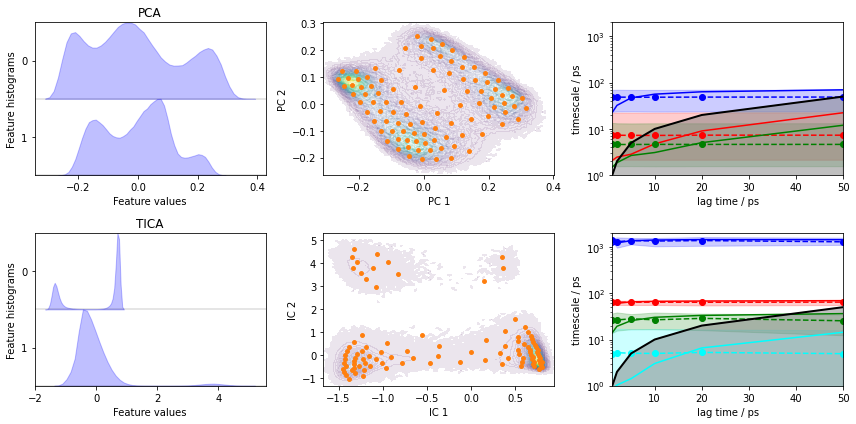

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
pyemma.plots.plot_feature_histograms(pca_concatenated, ax=axes[0, 0])
pyemma.plots.plot_feature_histograms(tica_concatenated, ax=axes[1, 0])
axes[0, 0].set_title('PCA')
axes[1, 0].set_title('TICA')
pyemma.plots.plot_density(*pca_concatenated.T, ax=axes[0, 1], cbar=False, alpha=0.1)
axes[0, 1].scatter(*cls_pca.cluster_centers.T, s=15, c='C1')
axes[0, 1].set_xlabel('PC 1')
axes[0, 1].set_ylabel('PC 2')
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1, 1], cbar=False, alpha=0.1)
axes[1, 1].scatter(*cls_tica.cluster_centers.T, s=15, c='C1')
axes[1, 1].set_xlabel('IC 1')
axes[1, 1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_pca, ax=axes[0, 2], units='ps')
pyemma.plots.plot_implied_timescales(its_tica, ax=axes[1, 2], units='ps')
axes[0, 2].set_ylim(1, 2000)
axes[1, 2].set_ylim(1, 2000)
fig.tight_layout()

Despite the fact that PCA yields a projection with some defined basins,
the ITS plot shows that only one "slow" process is resolved which is more than one order of magnitude too fast.

TICA does find three slow processes which agree (in terms of the implied timescales) with the backbone torsions example above.

We conclude that this PCA projection is not suitable to resolve the slow dynamics of alanine dipeptide and we will continue to estimate/validate the TICA-based projection.

#### Exercise 2

Estimate a Bayesian MSM at lag time $10$ ps and perform/show a CK test for four metastable states.

In [ ]:
counts_estimator = dt.markov.TransitionCountEstimator(lagtime=10, count_mode="effective")
counts = counts_estimator.fit(dtrajs_tica).fetch_model().submodel_largest()
bayesian_msm = # FIXME
pyemma.plots. #FIXME

###### Solution

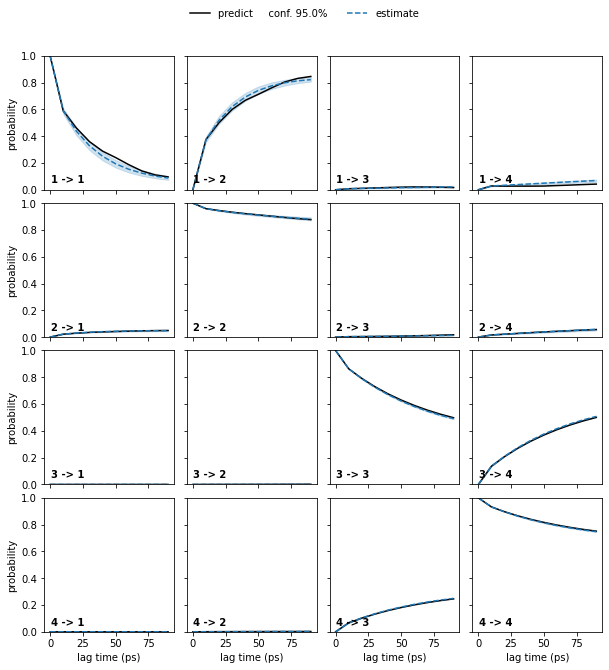

In [29]:
counts_estimator = dt.markov.TransitionCountEstimator(lagtime=10, count_mode="effective")
counts = counts_estimator.fit(dtrajs_tica).fetch_model().submodel_largest()

estimator = dt.markov.msm.BayesianMSM()
estimator.fit(counts)
validator = estimator.chapman_kolmogorov_validator(4, mlags=10)
cktest = validator.fit(dtrajs_tica).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');

We again see a good agreement between model prediction and re-estimation.

## Wrapping up
In this notebook, we have learned how to estimate a regular or Bayesian MSM from discretized molecular simulation data with `deeptime` and `pyemma`, also how to perform basic model validation.

In detail, we have selected a suitable lag time by
- computing timescales from MSMs and Bayesian MSMs
- `pyemma.plots.plot_implied_timescales()` to visualize the convergence of the implied timescales.

We then have used
- `dt.markov.TransitionCountEstimator()` to estimate transition counts
- `dt.markov.msm.MaximumLikelihoodMSM()` to estimate a regular MSM,
- `dt.markov.msm.BayesianMSM()` to estimate a Bayesian MSM,
- the `timescales()` method of an estimated MSM object to access its implied timescales,
- the `chapman_kolmogorov_validator()` method of an estimated MSM estiamator to perform a Chapman-Kolmogorow test, and
- `pyemma.plots.plot_cktest()` to visualize the latter.